In [1]:
%pylab inline
import pandas as pd

from mpl_toolkits.axes_grid.inset_locator import inset_axes

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('BC_final_results.csv', index_col=0)
ms_results = pd.read_csv('BC_MS_results.csv', index_col=0)
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(250, 12856)

In [3]:
sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

In [4]:
import GPy
import GPclust

In [5]:
np.random.seed(10)

m = GPclust.MOHGP(X=X,
                  Y=Y,
                  kernF=GPy.kern.RBF(2) + GPy.kern.Bias(2),
                  kernY=GPy.kern.RBF(1) + GPy.kern.White(1),
                  K=5,
                  prior_Z='DP')

m.hyperparam_opt_args['messages'] = False

m.optimize(step_length=0.1, verbose=False, maxiter=2000)

In [6]:
m

MOHGP.,value,constraints,priors
sum.rbf.variance,0.213993775262,+ve,
sum.rbf.lengthscale,0.948296256392,+ve,
sum.bias.variance,35.072351279,+ve,
sum_1.rbf.variance,1.81095953775,+ve,
sum_1.rbf.lengthscale,82.5431934021,+ve,
sum_1.white.variance,0.465917595913,+ve,


In [7]:
m.phi_hat

array([ 43.0192761 ,  37.98427071,   5.        ,  18.99871405,   9.99773914])

In [8]:
sres['cluster'] = m.phi_.argmax(1)
Cs = m.predict_components(X)

K_hat = len(sres.cluster.unique())
K_hat

5

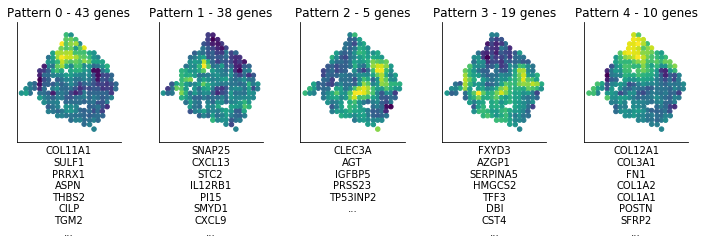

In [39]:
figsize(10, 3.5)
for i, Ci in enumerate(sres.sort_values('cluster').cluster.unique()):
    C = Cs[0][Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(Ci, sres.query('cluster == @Ci').shape[0] ))
    
    xlab = '\n'.join(sres.query('cluster == @Ci').sort_values('pval')['g'].tolist()[:7])
    plt.xlabel(xlab + '\n...')
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('BC_AEH.pdf', bbox_inches='tight')

In [31]:
for i in sres.sort_values('cluster').cluster.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(sres.query('cluster == @i').sort_values('pval')['g'].tolist()))
    print()

Pattern 0
COL11A1, SULF1, PRRX1, ASPN, THBS2, CILP, TGM2, DCN, CTHRC1, SOD2, FGB, HTRA1, ANTXR1, COL5A2, COL5A1, VCAN, GBP1, SPP1, B2M, MMP13, CTSK, FGG, RARRES1, MAFB, TNC, BASP1, CCDC80, PALLD, VIM, FCGR3A, AEBP1, HMCN1, LOX, C1S, COL10A1, CRISPLD2, HLA-DRA, TMSB4X, C3, ADAMTS2, MMP11, LRRC15, GJA1

Pattern 1
SNAP25, CXCL13, STC2, IL12RB1, PI15, SMYD1, CXCL9, SSPO, ZNF880, RPL41, ETV7, WDR5B, ACTL8, ITGAX, TFF1, CST3, RPL13, RPL29, TYW5, IL21R, ITIH2, C2orf40, ZNF280C, MMP10, SAA1, EEF1A2, SLC16A6, GPIHBP1, IGLL5, GHRH, HPS3, PNMT, KLHL15, RPL8, PAQR8, RPL28, PEG10, SLX4

Pattern 2
CLEC3A, AGT, IGFBP5, PRSS23, TP53INP2

Pattern 3
FXYD3, AZGP1, SERPINA5, HMGCS2, TFF3, DBI, CST4, SPINT2, BEX1, LY6E, PPP1R1B, GPC3, COX6B1, CTSD, WFDC2, STARD10, CST1, BST2, HPN

Pattern 4
COL12A1, COL3A1, FN1, COL1A2, COL1A1, POSTN, SFRP2, LUM, SPARC, COL6A3

